### This notebook can be used to run K means clustering iteratively.
- It makes use of a csv file already **cleaned** and **trimmed** down. The rows in the csv file are paragraphs from the entire corpus. 
- The column **'clean_text'** are words from the paragraph that are already stemmed and tokenized.
- The **'clean_text'** column is vectorized using TF-IDF from Scikit-Learn. Dask is used to speed up the process on the large dataset.
- The goal is to cluster on the vectorized words in an iterative process, repeatedly removing words that are boilerplate language or other generic words that would not pertain to relevant risk disclosures.

In [1]:
first_time = True

Run this to display progress bar:

In [2]:
from tqdm import tqdm

Run this cell only once to download 'stopwords' and 'punkt':

In [3]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/montsieguerrero/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/montsieguerrero/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

Import packages

In [4]:
import string
import pickle
import joblib

import numpy as np
import pandas as pd
import nltk
import re
import os

from sklearn.metrics.pairwise import cosine_similarity
from matplotlib import pyplot as plt

%matplotlib inline 


from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.preprocessing import normalize


from sklearn.cluster import KMeans
from sklearn.manifold import MDS

### Read Dataframe

In [5]:
documents = pd.read_csv("def14a_para_clean.csv")
print(documents.shape)
documents.tail()

(406160, 4)


,Unnamed: 0,file_name,text,clean_text
406155,1842980,HFC_DEF 14A_20190508_0001193125-19-081851.txt,If you would like to reduce the costs incurred...,would like reduc cost incur compani mail proxi...
406156,1842993,HFC_DEF 14A_20190508_0001193125-19-081851.txt,Please sign exactly as your name(s) appear(s)...,pleas sign exactli name appear hereon sign att...
406157,1842994,HFC_DEF 14A_20190508_0001193125-19-081851.txt,Please sign exactly as your name(s) appear(s)...,pleas sign exactli name appear hereon sign att...
406158,1843004,HFC_DEF 14A_20190508_0001193125-19-081851.txt,The stockholder(s) hereby appoint George J. Da...,stockhold herebi appoint georg damiri richard ...
406159,1843005,HFC_DEF 14A_20190508_0001193125-19-081851.txt,"This proxy, when properly executed, will be vo...",proxi properli execut vote manner direct herei...


In [5]:
#RUN to add File Path
documents['file_name'] = 'clean_text3/' + documents['file_name']

In [9]:
# create a dataframe from a word matrix
def wm2df(wm, feat_names):
    
    # create an index for each row
    doc_names = ['Par{:d}'.format(idx) for idx, _ in enumerate(wm)]
    df = pd.DataFrame(data=wm.toarray(), index=doc_names,
                      columns=feat_names)
    return(df)


### Vectorize the Words: TF-IDF

In [6]:
#RUN THIS ONE
tfidf_vectorizer = TfidfVectorizer()
X_tfidf = tfidf_vectorizer.fit_transform(tqdm(documents['clean_text'].values.astype('U')))
X_tfidf = normalize(X_tfidf)
tfidf_features = tfidf_vectorizer.get_feature_names()

100%|██████████| 406160/406160 [00:51<00:00, 7855.63it/s]


In [40]:
wm2df(X_tfidf, tfidf_features)

,aa,aaa,aaaa,aabi,aac,aaca,aachen,aacr,aadvantag,aaf,...,ûpay,ûprovid,ûwe,üour,üthe,ütie,üwe,üü,δe,开心汽车
Par0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Par1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Par2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Par3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Par4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Par406155,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Par406156,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Par406157,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
Par406158,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Convert to Dataframe

In [7]:
tf_idf_array_1 = X_tfidf.toarray()
uni_df = pd.DataFrame(tf_idf_array_1, columns=tfidf_features)

In [8]:
print(uni_df.shape)
uni_df.head()

(406160, 47200)


,aa,aaa,aaaa,aabi,aac,aaca,aachen,aacr,aadvantag,aaf,...,ûpay,ûprovid,ûwe,üour,üthe,ütie,üwe,üü,δe,开心汽车
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Change the number of clusters based on the optimal number

In [31]:
#Dask ML
from dask.distributed import Client
import joblib

client = Client()

within_cluster_variance = []


for k in range(2, 21):
    kmeans = KMeans(n_clusters=k)
    
    with joblib.parallel_backend('dask'):
        kmeans.fit(X_tfidf)
    within_cluster_variance.append(kmeans.inertia_)



In [32]:
within_cluster_variance

[382861.52510867413,
 376930.7761868613,
 372833.95375051326,
 369225.1388356419,
 366217.12279928837,
 363877.1476788711,
 362003.3775324536,
 360183.763768038,
 358398.26909303234,
 356922.446105372,
 355507.58778395667,
 354181.341208379,
 352897.70965394867,
 351855.0844835626,
 350796.3268018647,
 349697.0921598212,
 349006.1259268421,
 348343.7591091835,
 346770.7260424156]

Run this to see the graph:

Text(0.5, 1.0, 'Elbow curve')

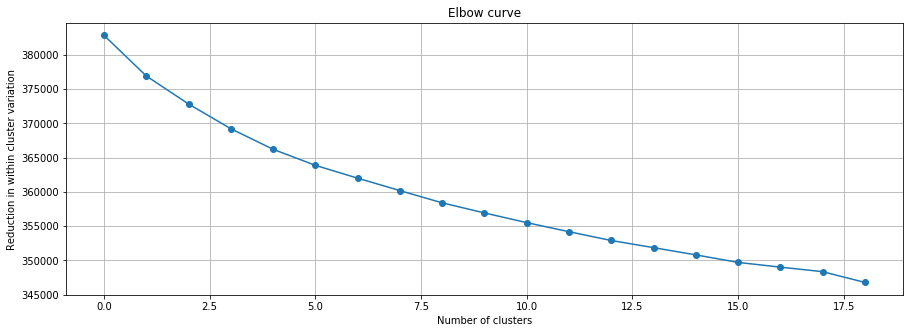

In [33]:
#elbow curve
fig = plt.figure(figsize=(15, 5))
plt.plot(range(19), within_cluster_variance, marker='o')
plt.grid()
plt.xlabel('Number of clusters')
plt.ylabel('Reduction in within cluster variation')

plt.title('Elbow curve') 

Math formula for Optimal Clusters: https://jtemporal.com/kmeans-and-elbow-method/

In [28]:
import math
def optimal_number_of_clusters(wcss):
    x1, y1 = 2, wcss[0]
    x2, y2 = 20, wcss[len(wcss)-1]

    distances = []
    for i in range(len(wcss)):
        x0 = i+2
        y0 = wcss[i]
        numerator = abs((y2-y1)*x0 - (x2-x1)*y0 + x2*y1 - y2*x1)
        denominator = math.sqrt((y2 - y1)**2 + (x2 - x1)**2)
        distances.append(numerator/denominator)
    
    return distances.index(max(distances)) + 2

In [34]:
optimal_number_of_clusters(within_cluster_variance)

7

### After finding optimal clusters using math formula, run the Kmeans model.

In [9]:
from dask.distributed import Client
import joblib

client = Client()  # Connect to a Dask Cluster

num_clusters = 7

uni_km = KMeans(n_clusters=num_clusters, n_jobs = None)

with joblib.parallel_backend('dask'):
    uni_km.fit(X_tfidf)



/Users/montsieguerrero/opt/anaconda3/lib/python3.7/site-packages/sklearn/cluster/_kmeans.py:974: FutureWarning: 'n_jobs' was deprecated in version 0.23 and will be removed in 0.25.
  " removed in 0.25.", FutureWarning)


In [10]:
#RUN
uni_clusters = uni_km.labels_.tolist() #labels

### Change directory where the pickle file will go

In [16]:
#Path to folder
data_dir = 'cluster_pkl' #directory name

#name of new file to be pickled, change everytime you run clustering model
cluster_file = '/uni_doc_cluster_5.pkl' 
path = data_dir + cluster_file

Run this code to add pickle doc into the clusker_pkl folder:

In [17]:
#RUN ONLY WHEN NUM OF CLUSTERS ARE NEW
joblib.dump(uni_km,  open( path, "wb" )) #pickle doc

### Load Pickle doc

In [18]:
#RUN
#Loading the pkl doc

uni_km_load = joblib.load(path)
uni_clusters = uni_km_load.labels_.tolist() #labels

uni_clust_centers = uni_km_load.cluster_centers_ # centers

### Get Top Keywords

In [43]:
for i, clust in enumerate(uni_clust_centers): #cluster centers
    terms_clust = zip(tfidf_features, clust) #words + cluster center
    sorted_terms = sorted(terms_clust, key= lambda x:x[1], reverse=True)[:10] #10 words, reversed order
    print("Topic "+str(i+1)+": ")
    for t in sorted_terms:
        print(t[0])
        print(" ")

Topic 1: 
compani
 
plan
 
agreement
 
benefit
 
termin
 
execut
 
share
 
perform
 
employe
 
particip
 
Topic 2: 
stock
 
award
 
share
 
option
 
grant
 
vest
 
exercis
 
plan
 
restrict
 
common
 
Topic 3: 
presid
 
sinc
 
serv
 
director
 
experi
 
chief
 
board
 
vice
 
offic
 
manag
 
Topic 4: 
compens
 
execut
 
committe
 
perform
 
offic
 
incent
 
program
 
compani
 
base
 
annual
 
Topic 5: 
audit
 
committe
 
independ
 
account
 
financi
 
regist
 
public
 
firm
 
auditor
 
report
 
Topic 6: 
board
 
director
 
committe
 
govern
 
nomin
 
meet
 
independ
 
corpor
 
member
 
nomine
 
Topic 7: 
vote
 
proxi
 
meet
 
annual
 
propos
 
share
 
instruct
 
stockhold
 
broker
 
card
 


### Add the cluster and file columns to the dataframe

In [53]:
uni_df_cl = uni_df.copy()
uni_df_cl['clusters'] = uni_clusters
uni_df_cl['file_name'] = documents['file_name'] 
uni_df_cl.head()

,aa,aaa,aaaa,aabi,aac,aaca,aachen,aacr,aadvantag,aaf,...,ûwe,üour,üthe,ütie,üwe,üü,δe,开心汽车,clusters,file_name
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,clean_text3/_UNK_DEF 14A_20181110_0001213900-1...
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,6,clean_text3/_UNK_DEF 14A_20181110_0001213900-1...
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,clean_text3/_UNK_DEF 14A_20181110_0001213900-1...
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,clean_text3/_UNK_DEF 14A_20181110_0001213900-1...
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0,clean_text3/_UNK_DEF 14A_20181110_0001213900-1...


### RUNNING RECORD: Add the Cluster topics and Words Here
### All iterations of the kmeans model
1. Using the optimal number of clusters 7:



    Topic 1: compani, plan, agreement, benefit, termin, execut, share, perform, employe, particip
    
    Topic 2: stock, award, share, option, grant, vest, exercis, plan, restrict, common
 
    Topic 3: presid, sinc, serv, director, experi, chief, board, vice, offic, manag
 
    Topic 4: compens, execut, committe, perform, offic, incent, program, compani, base, annual
 
    Topic 5: audit, committe, independ, account, financi, regist, public, firm, auditor, report
 
    Topic 6: board, director, committe, govern, nomin, meet, independ, corpor, member, nomine
 
    Topic 7: vote, proxi, meet, annual, propos, share, instruct, stockhold, broker, card

Observe the words in the clusters and detect which ones are generic. Then eliminate these words from the dataframe and rerun the model.